<a href="https://colab.research.google.com/github/IsaacDayan/StringLookupBug/blob/main/StringLookupDiscrepancyAccuracyBetweenEagerAndGraphMinimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
PATH = "/content/"

# New section

In [ ]:
import numpy as np
import os
import time
import datetime
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution 
import random
import json
import collections

def reset_seed():
    try:
      tf.random.set_seed(12345)
      tf.compat.v1.random.set_random_seed(12345)
    except:
      try:
        tf.compat.v1.random.set_random_seed(12345)
      except:
        pass
    random.seed(12345)
    np.random.seed(12345)
    os.environ['PYTHONHASHSEED']=str(0)
reset_seed()

print("Tensorflow Version: ", tf.__version__)


Tensorflow Version:  2.3.0


In [ ]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
BATCH_SIZE = 32
# load jsons:        

user_idx= json.load(open(PATH + 'data/gist_user_idx.json', 'r'))

        
# sorted device index list:
user_idx_order = np.argsort(list(user_idx.values()))
user_idx = collections.OrderedDict(zip(np.array(list(user_idx.keys()))[user_idx_order], np.array(list(user_idx.values()))[user_idx_order]))

user_idx_list = list(user_idx.keys())


class PackNumericFeatures(object):
    def __init__(self, user_idx):
        self.user_lookup = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=user_idx,
                                                                                    mask_token=None,
                                                                                    num_oov_indices=1
                                                                                    )
    def __call__(self, features, labels):
        user = self.user_lookup(features['user'])
        print(features['user'],user)
        return user, labels


def build_model(loss=tf.keras.losses.binary_crossentropy):
    user_input = tf.keras.layers.Input(name='user_input', shape=(1,))
    x = tf.keras.layers.Dense(1, activation='sigmoid')(user_input)
    model = tf.keras.Model(inputs=user_input, outputs=x)
    model.compile(
        loss=loss,
        optimizer='adam',
        metrics=['accuracy'],
    )
    return model

EPOCHS = 2
STEPS_PER_EPOCH = 10

In [ ]:
# eager
with tf.device('/device:GPU:0'):
  for i in range(3):
    reset_seed()
    print("tf.executing_eagerly()",tf.executing_eagerly())
    pack_obj = PackNumericFeatures(user_idx_list)
    raw_data = tf.data.experimental.make_csv_dataset(
              PATH+"data/gist_learning_set_11.csv",
              column_names=['user', 'item', 'bought'],
              select_columns=['user', 'bought'],
              column_defaults=[tf.string, tf.int32],
              batch_size=BATCH_SIZE,
              label_name='bought',
              na_value="?",
              num_epochs=1,
              ignore_errors=True,
              shuffle_seed=12345,
              shuffle = False,
          )

    # train_data = raw_data.map(pack_obj).shuffle(buffer_size=10000).repeat()
    train_data = raw_data.map(pack_obj)
    model = build_model()
    r = model.fit(train_data,
                epochs=EPOCHS,
                steps_per_epoch=STEPS_PER_EPOCH,
                )
    # print("tf.executing_eagerly()",tf.executing_eagerly()

tf.executing_eagerly() True
Tensor("args_0:0", shape=(None,), dtype=string) Tensor("string_lookup/None_lookup_table_find/LookupTableFindV2:0", shape=(None,), dtype=int64, device=/job:localhost/replica:0/task:0/device:CPU:0)
Epoch 1/2
10/10 [==============================] - 0s 2ms/step - loss: 47599.8125 - accuracy: 0.5094
Epoch 2/2
10/10 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
tf.executing_eagerly() True
Tensor("args_0:0", shape=(None,), dtype=string) Tensor("string_lookup_1/None_lookup_table_find/LookupTableFindV2:0", shape=(None,), dtype=int64, device=/job:localhost/replica:0/task:0/device:CPU:0)
Epoch 1/2
10/10 [==============================] - 0s 2ms/step - loss: 47599.8125 - accuracy: 0.5094
Epoch 2/2
10/10 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
tf.executing_eagerly() True
Tensor("args_0:0", shape=(None,), dtype=string) Tensor("string_lookup_2/None_lookup_table_find/LookupTableFindV2:0", s

In [ ]:
# eager disable
print("tf.executing_eagerly()",tf.executing_eagerly())
reset_seed()
with tf.device('/device:GPU:0'):
  disable_eager_execution()
  print("tf.executing_eagerly()",tf.executing_eagerly())
  for i in range(3):
    pack_obj = PackNumericFeatures(user_idx_list)
    raw_data2 = tf.data.experimental.make_csv_dataset(
              PATH+"data/gist_learning_set_11.csv",
              column_names=['user', 'item', 'bought'],
              select_columns=['user', 'bought'],
              column_defaults=[tf.string, tf.int32],
              batch_size=BATCH_SIZE,
              label_name='bought',
              na_value="?",
              num_epochs=1,
              ignore_errors=True,
              shuffle_seed=12345,
              shuffle = False,
          )

    train_data2 = raw_data2.map(pack_obj).shuffle(buffer_size=10000).repeat()
    model2 = build_model()
    r = model2.fit(train_data2,
                epochs=EPOCHS,
                steps_per_epoch=STEPS_PER_EPOCH,
                # callbacks=callbacks
                )
    print("tf.executing_eagerly()",tf.executing_eagerly())

tf.executing_eagerly() True
tf.executing_eagerly() False
Tensor("args_0:0", shape=(None,), dtype=string) Tensor("string_lookup_3/string_lookup_3_index_table_lookup_table_find/LookupTableFindV2:0", shape=(None,), dtype=int64)
Train on 10 steps
Epoch 1/2
10/10 [==============================] - 0s 2ms/step - batch: 4.5000 - size: 1.0000 - loss: 0.6929 - accuracy: 0.6219
Epoch 2/2
10/10 [==============================] - 0s 2ms/step - batch: 4.5000 - size: 1.0000 - loss: 0.6925 - accuracy: 0.6406    
tf.executing_eagerly() False
Tensor("args_0:0", shape=(None,), dtype=string) Tensor("string_lookup_4/string_lookup_4_index_table_lookup_table_find/LookupTableFindV2:0", shape=(None,), dtype=int64)
Train on 10 steps
Epoch 1/2
10/10 [==============================] - 0s 2ms/step - batch: 4.5000 - size: 1.0000 - loss: 0.6934 - accuracy: 0.3562
Epoch 2/2
10/10 [==============================] - 0s 2ms/step - batch: 4.5000 - size: 1.0000 - loss: 0.6930 - accuracy: 0.8000
tf.executing_eagerly() Fal

## older executions
also give different results on each run

In [ ]:
# tf.executing_eagerly() True
# tf.executing_eagerly() False
# Tensor("args_0:0", shape=(None,), dtype=string) Tensor("string_lookup_1/string_lookup_1_index_table_lookup_table_find/LookupTableFindV2:0", shape=(None,), dtype=int64)
# Train on 10 steps
# Epoch 1/2
# 10/10 [==============================] - 0s 3ms/step - batch: 4.5000 - size: 1.0000 - loss: 0.6940 - accuracy: 0.5000    
# Epoch 2/2
# 10/10 [==============================] - 0s 2ms/step - batch: 4.5000 - size: 1.0000 - loss: 0.6935 - accuracy: 0.5000
# tf.executing_eagerly() False

tf.executing_eagerly() True

tf.executing_eagerly() False

Tensor("args_0:0", shape=(None,), dtype=string) Tensor("string_lookup_1/string_lookup_1_index_table_lookup_table_find/LookupTableFindV2:0", shape=(None,), dtype=int64)

Train on 10 steps

Epoch 1/2
10/10 [==============================] - 0s 2ms/step - batch: 4.5000 - size: 1.0000 - loss: 0.6933 - accuracy: 0.6000

Epoch 2/2
10/10 [==============================] - 0s 2ms/step - batch: 4.5000 - size: 1.0000 - loss: 0.6990 - accuracy: 0.1000    

tf.executing_eagerly() False

In [ ]:
model = build_model()
model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
user_input (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


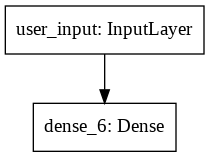

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)
